<a href="https://colab.research.google.com/github/ckhkc/Wind-Power-Forecasting/blob/main/wind_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt

In [ ]:
# ==========================================
# 1. Data Loading & Feature Engineering
# ==========================================
def load_and_process_data(filepath):
    # Load dataset [file:1]
    df = pd.read_csv(filepath)
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)

    # Cyclic Time Features
    seconds_in_day = 24 * 60 * 60
    seconds_in_year = (365.2425) * 24 * 60 * 60

    df['timestamp'] = df['time'].map(pd.Timestamp.timestamp)
    df['day_sin'] = np.sin(df['timestamp'] * (2 * np.pi / seconds_in_day))
    df['day_cos'] = np.cos(df['timestamp'] * (2 * np.pi / seconds_in_day))
    df['year_sin'] = np.sin(df['timestamp'] * (2 * np.pi / seconds_in_year))
    df['year_cos'] = np.cos(df['timestamp'] * (2 * np.pi / seconds_in_year))

    # Cyclic Wind Direction (Input Features)
    wd_rad = df['Wind_Direction'] * np.pi / 180
    df['wd_sin'] = np.sin(wd_rad)
    df['wd_cos'] = np.cos(wd_rad)

    # Feature List
    feature_cols = ['Temperature', 'Wind_Speed', 'wd_sin', 'wd_cos',
                    'day_sin', 'day_cos', 'year_sin', 'year_cos']

    return df[feature_cols].values, feature_cols

In [ ]:
# ==========================================
# 2. ResNet Model Definition
# ==========================================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out

class WeatherResNet(nn.Module):
    def __init__(self, input_dim, output_dim=3, num_filters=64, num_blocks=3):
        super(WeatherResNet, self).__init__()
        # Initial projection
        self.initial_conv = nn.Sequential(
            nn.Conv1d(input_dim, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm1d(num_filters),
            nn.ReLU(inplace=True)
        )
        # Residual Blocks
        self.blocks = nn.ModuleList([
            ResidualBlock(num_filters, num_filters) for _ in range(num_blocks)
        ])
        # Output Head
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(num_filters, output_dim)

    def forward(self, x):
        # Permute for Conv1d: (Batch, Seq, Feat) -> (Batch, Feat, Seq)
        x = x.permute(0, 2, 1)
        out = self.initial_conv(x)
        for block in self.blocks:
            out = block(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# ==========================================
# 3. Data Processing Utils
# ==========================================
def create_multi_target_sequences(data, seq_length, target_indices):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length, target_indices])
    return np.array(xs), np.array(ys)

def recover_angle_degrees(sin_vals, cos_vals):
    angles = np.arctan2(sin_vals, cos_vals)
    degrees = np.degrees(angles)
    return (degrees + 360) % 360

Training on cuda...
Epoch 10: Avg Loss = 0.0560
Epoch 20: Avg Loss = 0.0430
Epoch 30: Avg Loss = 0.0283
Epoch 40: Avg Loss = 0.0260
Epoch 50: Avg Loss = 0.0168

Final Results:
Wind Speed RMSE: 1.6878
Wind Direction MAE: 22.2474


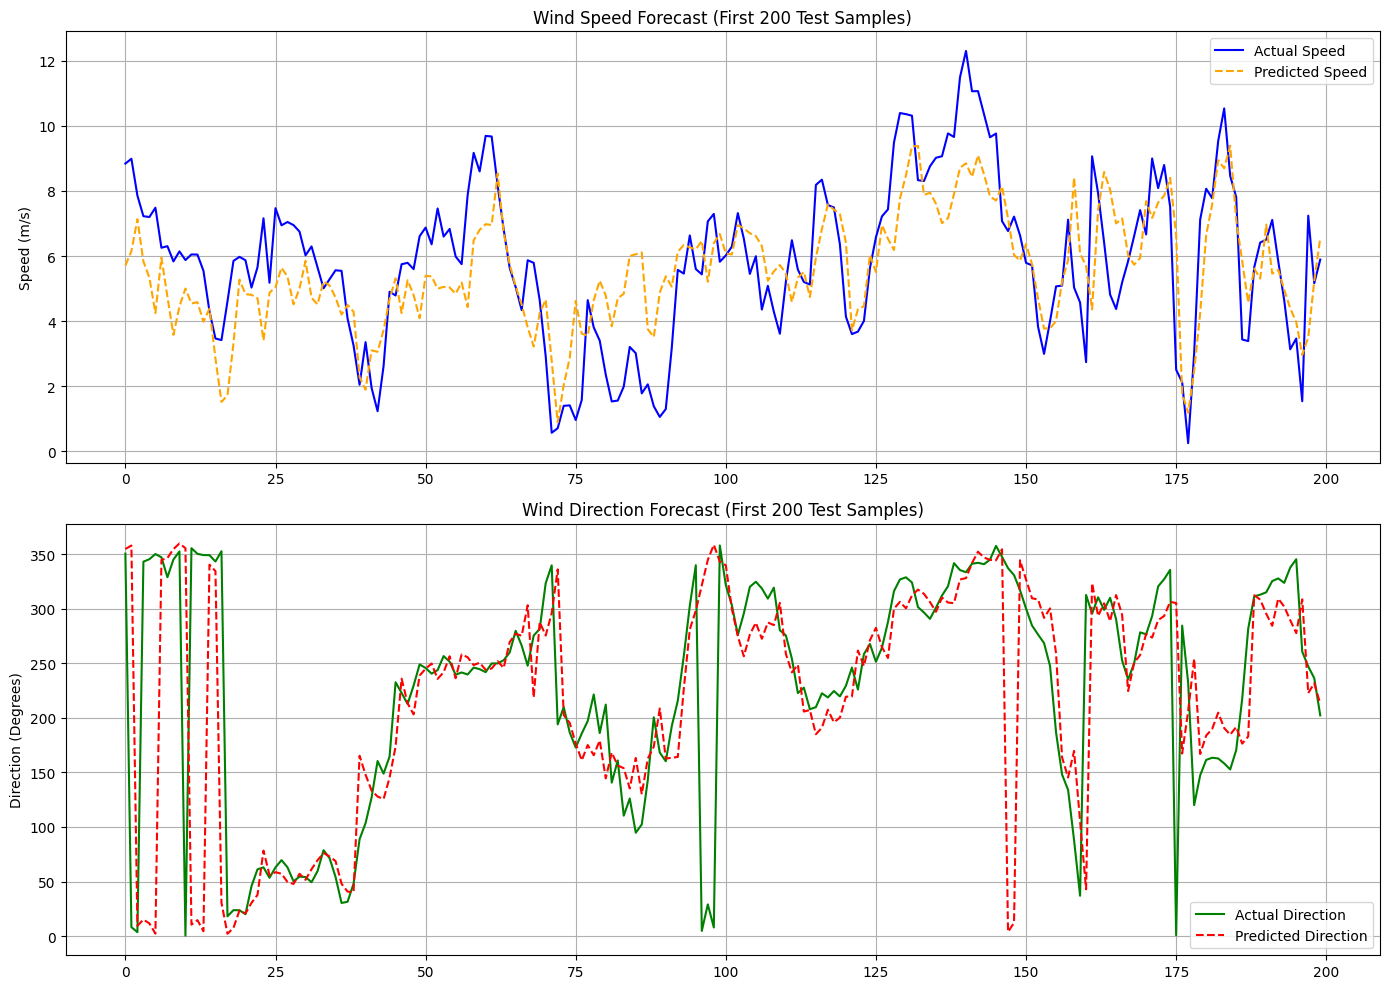

In [ ]:
# ==========================================
# 4. Main Execution
# ==========================================
if __name__ == "__main__":
    # Settings
    FILE_PATH = '2016_full_year_weather.csv'
    SEQ_LENGTH = 24
    BATCH_SIZE = 64
    EPOCHS = 50

    # A. Load & Scale
    data, features = load_and_process_data(FILE_PATH)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)

    # B. Create Sequences
    # Indices: Wind_Speed=1, wd_sin=2, wd_cos=3
    target_indices = [1, 2, 3]
    X, y = create_multi_target_sequences(scaled_data, SEQ_LENGTH, target_indices)

    # C. Split Train/Test
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # D. Dataloaders
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    test_data = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    # E. Model & Training
    model = WeatherResNet(input_dim=len(features), output_dim=3).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Training on {device}...")
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}: Avg Loss = {total_loss/len(train_loader):.4f}")

    # F. Evaluation
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            preds = model(inputs)
            all_preds.append(preds.cpu().numpy())

    raw_preds = np.concatenate(all_preds)

    # G. Inverse Transform (Recover original scale)
    # Create dummy matrix matching original feature count
    dummy_pred = np.zeros((len(raw_preds), len(features)))
    dummy_act = np.zeros((len(y_test), len(features)))

    # Fill predicted columns
    dummy_pred[:, 1] = raw_preds[:, 0] # Speed
    dummy_pred[:, 2] = raw_preds[:, 1] # Sin
    dummy_pred[:, 3] = raw_preds[:, 2] # Cos

    # Fill actual columns
    dummy_act[:, 1] = y_test[:, 0]
    dummy_act[:, 2] = y_test[:, 1]
    dummy_act[:, 3] = y_test[:, 2]

    # Inverse transform
    inv_pred = scaler.inverse_transform(dummy_pred)
    inv_act = scaler.inverse_transform(dummy_act)

    # Extract final values
    pred_speed = inv_pred[:, 1]
    pred_dir = recover_angle_degrees(inv_pred[:, 2], inv_pred[:, 3])

    act_speed = inv_act[:, 1]
    act_dir = recover_angle_degrees(inv_act[:, 2], inv_act[:, 3])

    # H. Metrics
    speed_rmse = math.sqrt(mean_squared_error(act_speed, pred_speed))

    # Angular difference handling
    diff = np.abs(act_dir - pred_dir)
    dir_error = np.minimum(diff, 360 - diff)
    dir_mae = np.mean(dir_error)

    print(f"\nFinal Results:")
    print(f"Wind Speed RMSE: {speed_rmse:.4f}")
    print(f"Wind Direction MAE: {dir_mae:.4f}")

    # I. Plotting
    plt.figure(figsize=(14, 10))

    # Plot Speed
    plt.subplot(2, 1, 1)
    plt.plot(act_speed[:200], label='Actual Speed', color='blue')
    plt.plot(pred_speed[:200], label='Predicted Speed', color='orange', linestyle='--')
    plt.title('Wind Speed Forecast (First 200 Test Samples)')
    plt.ylabel('Speed (m/s)')
    plt.legend()
    plt.grid(True)

    # Plot Direction
    plt.subplot(2, 1, 2)
    plt.plot(act_dir[:200], label='Actual Direction', color='green')
    plt.plot(pred_dir[:200], label='Predicted Direction', color='red', linestyle='--')
    plt.title('Wind Direction Forecast (First 200 Test Samples)')
    plt.ylabel('Direction (Degrees)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
